In [6]:
from tqdm import tqdm
import numpy as np
import pandas as pd
from scipy.interpolate import splrep, splev
import datetime as dt
import matplotlib.pyplot as plt
from fbprophet import Prophet
from scipy.interpolate import InterpolatedUnivariateSpline
%matplotlib inline
plt.rcParams.update({'font.size': 18})

In [7]:
def smape(satellite_predicted_values, satellite_true_values):
    # the division, addition and subtraction are pointwise
    return np.mean(np.abs((satellite_predicted_values - satellite_true_values)/
                (np.abs(satellite_predicted_values) + np.abs(satellite_true_values))))


def drop_close(t, x, eps=10**9):
    '''
    t = time array, x = data array, eps is in nanoseconds
    Returns entries in t,x with corresponding consecutive times > eps
    
    '''
    t = np.array(t) #if not already np array, convert
    x = np.array(x) #if t or x are pandas Series, will have dimension mismatch
    far = np.concatenate([(t[1:] - t[:-1]) > eps, [True]])
    return t[far], x[far]


def resample(t, x, step=10 * 10**9, t_new=None, return_t=False):
    '''
    t: time array (or series); 
    x: data array (or series); 
    t_new: new time scale from start to end of t with step size step;
    step: = 10 seconds by default; 
    return_t: by default, do not return resampled times
    
    resample time series or array by 10 (default) sec intervals and 
    return new time series (if t_new=True) and spline approximation series for data
    
    
    '''
    t, x = drop_close(t, x)
    if t_new is None:
        t_new = np.arange(t[0], t[-1], step)
    try:
        spl = splrep(t, x)
        x_new = splev(t_new, spl)
    except:
        raise ValueError(f'interpolation error, x length = {len(x)}, \
        t_new length = {len(t_new)}')

    return (t_new, x_new) if return_t else x_new


def get_peaks(array):
    '''
    returns index of "sharp" peaks, excluding first and last values of array
    
    index of "smooth peaks", e.g. 1 2 3 9 9 3 2 1, is not returned
    '''
    return np.where((array[1:-1] > array[2:]) & (array[1:-1] > array[:-2]))[0] + 1


def get_satellite_data(data, sat_id):
    '''
    returns all data for particular satellite by id
    '''
    return data[data['sat_id'] == sat_id]


def remove_time_jumps(satellite_data, features_list=('x_sim', 'y_sim', 'z_sim', 'Vx_sim', 'Vy_sim', 'Vz_sim'),
                      suffix='_jumps_removed',time_threshold = 0.00003):
    #time_threshold 0.00003 sufficient for test and train
    #time_threshold 0.00002 will throw errors
    '''
    removes time jumps in the simulation for a single satellite
    for train and test data, sufficient to set time_threshold at default
    '''
    satellite_data['t'] = ((pd.to_datetime(satellite_data['epoch']) - pd.to_datetime(satellite_data['epoch'])[0]) /
                           np.timedelta64(1, 'D')).astype(float)
    satellite_data['dt'] = satellite_data['t'].diff()
    # the most frequent time interval
    t_standard = satellite_data['dt'].value_counts().index[0]

    # time steps used for simulations
    satellite_data['t_sim'] = satellite_data.index.values * t_standard

    n = satellite_data.shape[0]
    corrected_features = []
    for feature_name in features_list:
        corrected_feature = [0] * n
        corrected_feature[0] = satellite_data[feature_name][0]

        feature = satellite_data[feature_name]

        for j in range(1, n - 1):
            if satellite_data.t[j] < satellite_data.t_sim[j] - time_threshold:
                # approximate by the left side
    
                # look for the interval
                step = 0
                while satellite_data.t[j] < satellite_data.t_sim[j - step] - time_threshold:
                    step += 1
                #             print(step)
                corrected_feature[j] = feature[j - step] - (satellite_data.t_sim[j - step] - satellite_data.t[j]) / (
                            satellite_data.t_sim[j - step] - satellite_data.t_sim[j - step - 1]) * (
                                              feature[j - step] - feature[j - step - 1])
            elif satellite_data.t[j] > satellite_data.t_sim[j] + time_threshold:
                # approximate by the right side
    
                # look for the interval
                step = 0
                while satellite_data.t[j] > satellite_data.t_sim[j + step] + time_threshold:
                    step += 1
    
                corrected_feature[j] = feature[j + step + 1] - (satellite_data.t_sim[j + step + 1] - satellite_data.t[j]) / (
                            satellite_data.t_sim[j + step + 1] - satellite_data.t_sim[j + step]) * (
                                              feature[j + step + 1] - feature[j + step])
            else:
                corrected_feature[j] = feature[j]
    
        corrected_feature[n - 1] = feature[n - 1] + corrected_feature[n - 2] - feature[n - 2]
        corrected_features.append(corrected_feature)
    return pd.DataFrame(corrected_features, index=[f + suffix for f in features_list]).T

In [8]:
def insert_previous_and_shift(df,col_name,ind):
    '''
    input a data frame (df), column name (col_name), and index (ind)
    insert previous value of df[col_name] at index and shift the rest 
    of df[col_name] from ind by +1;
    This is used for remove_time_jumps_fast
    '''
    shifted_series = df[col_name].shift(1)
    df[col_name].iloc[ind] = df[col_name].iloc[ind-1]
    df[col_name].iloc[ind+1:] = shifted_series.iloc[ind+1:]
    return df

In [9]:
def remove_time_jumps_fast(data, features_list=
                           ('x_sim', 'y_sim', 'z_sim', 'Vx_sim', 'Vy_sim', 'Vz_sim'),
                           threshold = 0.000001):
    #time_threshold 0.00003 sufficient for test and train
    #time_threshold 0.00002 will throw errors
    '''
    removes time jumps in the simulation for a single satellite
    for train and test data, sufficient to set time_threshold at default
    s_data = satellite data
    the features are replaced by the correction
    note that threshold here is not the same as in remove_time_jumps
    '''
    data['t'] = ((pd.to_datetime(data['epoch']) - pd.to_datetime(data['epoch'])[0]) /
                               np.timedelta64(1, 'D')).astype(float)
    data['dt'] = data['t'].diff(1)

    index_for_correction = data[data['dt'] < threshold].index 
    #print(index_for_correction)
    if list(index_for_correction): #if non empty
        for feature in features_list:
            for i in index_for_correction:
                data = insert_previous_and_shift(data,feature,i)
    return data

## Transforming all the data

In [10]:
features_list=['x', 'y', 'z', 'Vx', 'Vy', 'Vz']

In [11]:
data = pd.read_csv('data/train.csv', index_col = 'id')
data['time'] = data['epoch']
data['epoch'] = pd.to_datetime(data['epoch']).values.astype(float)
data.head()

,epoch,sat_id,x,y,z,Vx,Vy,Vz,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim,time
id,,,,,,,,,,,,,,,
0,1.388534e+18,0,-8855.823863,13117.780146,-20728.353233,-0.908303,-3.808436,-2.022083,-8843.131454,13138.221690,-20741.615306,-0.907527,-3.804930,-2.024133,2014-01-01T00:00:00.000
1,1.388537e+18,0,-10567.672384,1619.746066,-24451.813271,-0.302590,-4.272617,-0.612796,-10555.500066,1649.289367,-24473.089556,-0.303704,-4.269816,-0.616468,2014-01-01T00:46:43.000
2,1.388540e+18,0,-10578.684043,-10180.467460,-24238.280949,0.277435,-4.047522,0.723155,-10571.858472,-10145.939908,-24271.169776,0.274880,-4.046788,0.718768,2014-01-01T01:33:26.001
3,1.388543e+18,0,-9148.251857,-20651.437460,-20720.381279,0.715600,-3.373762,1.722115,-9149.620794,-20618.200201,-20765.019094,0.712437,-3.375202,1.718306,2014-01-01T02:20:09.001
4,1.388546e+18,0,-6719.092336,-28929.061629,-14938.907967,0.992507,-2.519732,2.344703,-6729.358857,-28902.271436,-14992.399986,0.989382,-2.522618,2.342237,2014-01-01T03:06:52.002


In [12]:
test_data = pd.read_csv('data/test.csv', index_col = 'id')
test_data['time'] = test_data['epoch']
test_data['epoch'] = pd.to_datetime(test_data['epoch']).values.astype(float)

In [61]:
d = data[data.sat_id == 317]
td = test_data[test_data.sat_id == 317]
new = pd.concat([d,td],  axis = 0, sort = False)
spl = InterpolatedUnivariateSpline(d['epoch'], d['x'])
roots = spl.roots()

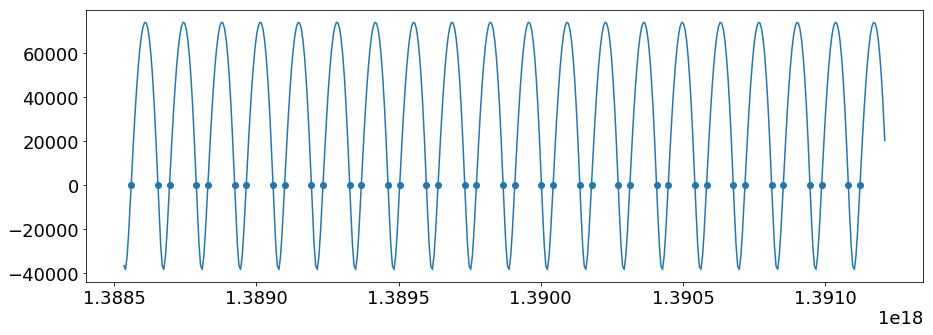

In [64]:
plt.figure(figsize=(15, 5))
#plt.plot(new['epoch'],new['x_sim'])
plt.plot(d['epoch'],d['x'])
plt.scatter(roots,[0]*len(roots));

38


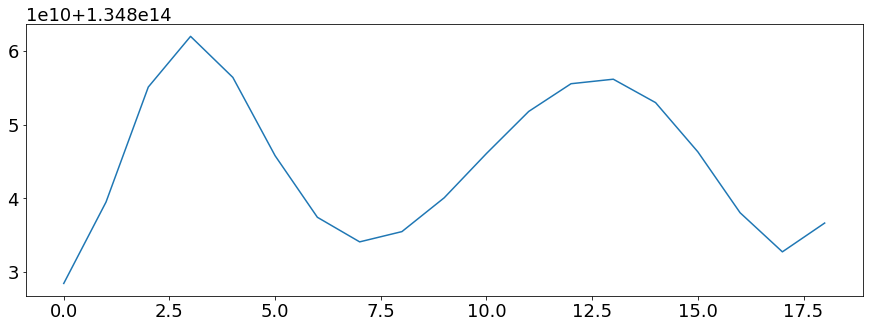

In [66]:
plt.figure(figsize=(15, 5))

#plt.plot(new['epoch'],new['x_sim'])
#plt.plot(d['epoch'],d['x'])

half_periods = np.diff(spl.roots())
print(len(half_periods))
periods = np.add.reduceat(half_periods, np.arange(0, len(half_periods), 2))
if len(half_periods)%2 != 0: #if odd # of observations, remove last (invalid) half period
    periods = periods[:-1]
plt.plot(periods);

In [13]:
result_df = []
alignment_model = LinearAlignment()

satellites_list = test_data['sat_id'].unique()

transf_df = pd.DataFrame([])
for sat_id in tqdm(satellites_list):
    
#     sat_data = utils.get_satellite_data(data, sat_id)
    try:
        sat_data = get_satellite_data(data, sat_id)
        n_first = sat_data.shape[0]
        
        test_sat_data = get_satellite_data(test_data, sat_id)
        
        sat_data = pd.concat([sat_data,test_sat_data], axis = 0, sort = False)
                
        index = sat_data.index
        pred = pd.DataFrame(index = index )
        
        sat_data = remove_time_jumps_fast(sat_data.reset_index(drop=True))
        sat_data.set_index(index)
#         sat_data = get_satellite_data(data, sat_id) # run to check the smape score before any transformations
    except KeyError as e:
        print(f'jump removal failed for satellite {sat_id}:\t{type(e).__name__} {e}')
        continue
    
    
    n_train = 4*len(sat_data) // 10
    
    train_sat_data = sat_data[:n_train]
    
    
    pred['epoch'] = sat_data['epoch'].values
    pred['t'] = sat_data['t'].values
    pred['sat_id'] = sat_id
    
    try:

        for feature_name in features_list:
            alignment_model.fit(t=train_sat_data['epoch'].values,
                                x=-train_sat_data[f'{feature_name}_sim'].values,
                                gt=-train_sat_data[feature_name].values)
            option1 = alignment_model.predict(t=sat_data['epoch'].values,
                                                         x=sat_data[f'{feature_name}_sim'].values)
            alignment_model.fit(t=train_sat_data['epoch'].values,
                                x= train_sat_data[f'{feature_name}_sim'].values,
                                gt= train_sat_data[feature_name].values)
            
            option2 = alignment_model.predict(t=sat_data['epoch'].values,
                                                         x=sat_data[f'{feature_name}_sim'].values)
            
            if utils.smape(option1[n_train:n_first],sat_data[feature_name].values[n_train:n_first]) < utils.smape(option2[n_train:n_first],sat_data[feature_name].values[n_train:n_first]):
                alignment_model.fit(t=sat_data['epoch'].iloc[:n_first].values,
                                x=-sat_data[f'{feature_name}_sim'].iloc[:n_first].values,
                                gt=-sat_data[feature_name].iloc[:n_first].values)
                    
                pred[f'{feature_name}_sim'] = alignment_model.predict(t=sat_data['epoch'].values,
                                                         x=sat_data[f'{feature_name}_sim'].values)
            else:
                alignment_model.fit(t=sat_data['epoch'].iloc[:n_first].values,
                                x=sat_data[f'{feature_name}_sim'].iloc[:n_first].values,
                                gt=sat_data[feature_name].iloc[:n_first].values)
                pred[f'{feature_name}_sim']  = alignment_model.predict(t=sat_data['epoch'].values,
                                                         x=sat_data[f'{feature_name}_sim'].values)
                
            pred.loc[:,feature_name]=sat_data.loc[:, feature_name].values
        
                  
            
    except Exception as e:
        print(f'linear alignment failed for satellite {sat_id}:\t{type(e).__name__} {e}')
        continue
    
    transf_df = transf_df.append(pred)

  0%|                                                                                          | 0/300 [00:00<?, ?it/s]C:\Users\Tatiana\Anaconda3\envs\idao\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [04:46<00:00,  1.04it/s]


In [15]:
transf_df.tail()

,epoch,t,sat_id,x_sim,x,y_sim,y,z_sim,z,Vx_sim,Vx,Vy_sim,Vy,Vz_sim,Vz
id,,,,,,,,,,,,,,,
1231060,1.393565e+18,58.221544,597,76906.939308,NaN,-59236.403348,NaN,-535.523943,NaN,-0.807110,NaN,-1.292839,NaN,0.163711,NaN
1231061,1.393572e+18,58.306788,597,70065.693017,NaN,-68040.376910,NaN,671.553602,NaN,-1.040613,NaN,-1.090759,NaN,0.163333,NaN
1231062,1.393579e+18,58.392032,597,61600.061178,NaN,-75266.613847,NaN,1862.786813,NaN,-1.249111,NaN,-0.863900,NaN,0.159153,NaN
1231063,1.393587e+18,58.477275,597,51690.108564,NaN,-80725.590472,NaN,3009.871459,NaN,-1.433450,NaN,-0.610073,NaN,0.151035,NaN
1231064,1.393594e+18,58.562519,597,40516.510035,NaN,-84205.829605,NaN,4082.665626,NaN,-1.592554,NaN,-0.325392,NaN,0.138577,NaN


In [16]:
transf_df.shape

(599254, 15)

In [17]:
sub = pd.read_csv('data/submission.csv')

In [26]:
sub_index = sub.id.values
sub.head()

,id,x,y,z,Vx,Vy,Vz
0,3927,-13366.891347,-14236.753503,6386.774555,4.333815,-0.692764,0.810774
1,3928,-7370.434039,-14498.771520,7130.411325,5.077413,0.360609,0.313402
2,3929,-572.068654,-13065.289498,7033.794876,5.519106,2.012830,-0.539412
3,3930,6208.945257,-9076.852425,5548.296900,4.849212,4.338955,-1.869600
4,3931,10768.200284,-2199.706707,2272.014862,1.940505,6.192887,-3.167724


In [50]:
q = transf_df.loc[sub_index,['x_sim', 'y_sim','z_sim','Vx_sim','Vy_sim','Vz_sim']]
q.columns = ['x','y','z','Vx','Vy','Vz']
# q = q.reset_index()
q.head()

,x,y,z,Vx,Vy,Vz
id,,,,,,
3927,-20234.180106,-12554.021795,5667.646483,3.484611,-1.868028,1.264194
3928,-15637.292764,-14050.528821,6744.069301,4.259422,-1.473909,1.107679
3929,-10053.451592,-14556.910761,7218.956173,5.013412,-0.863050,0.828353
3930,-3550.183845,-13505.949633,6663.844298,5.505161,0.093000,0.343701
3931,3426.309269,-10067.615863,4482.599249,5.003614,1.593562,-0.487549


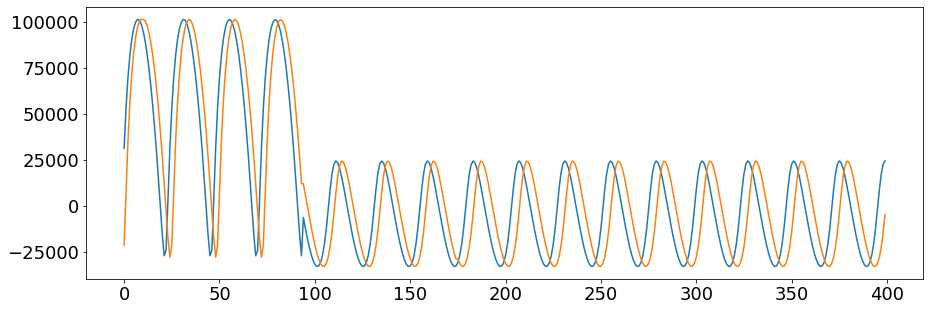

In [51]:
plt.figure(figsize=(15, 5))

plt.plot(sub.x.iloc[2500:2900].values)

plt.plot(q.x.iloc[2500:2900].values)

In [52]:
import datetime

submission_filename = 'submission_{}.csv'.format(
    datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))
q.to_csv(submission_filename)
print('Submission saved to {}'.format(submission_filename))

q.head(10)

Submission saved to submission_2020-01-28_12-30-56.csv


,x,y,z,Vx,Vy,Vz
id,,,,,,
3927,-20234.180106,-12554.021795,5667.646483,3.484611,-1.868028,1.264194
3928,-15637.292764,-14050.528821,6744.069301,4.259422,-1.473909,1.107679
3929,-10053.451592,-14556.910761,7218.956173,5.013412,-0.863050,0.828353
3930,-3550.183845,-13505.949633,6663.844298,5.505161,0.093000,0.343701
3931,3426.309269,-10067.615863,4482.599249,5.003614,1.593562,-0.487549
3932,9280.388630,-3651.655477,671.408666,2.283048,3.815583,-1.798337
3933,11346.640325,4200.805203,-3491.808855,-1.415976,5.960476,-3.128370
3934,9049.838121,10744.704564,-6777.020430,-3.549033,5.961191,-3.276736
3935,4357.666442,15028.859712,-9009.787419,-4.222716,4.300133,-2.524444
